<a href="https://colab.research.google.com/github/AbhiJ2706/predict-stocks-colab/blob/main/stock_tests_finished_predict_future(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*NOTE: Normally I would use data from the beginning of 2019, and this would produce much better results. However, since WorldTradingData was deprecated and I now have to use MarketStack, I now only have access to data from the last 6 months, which hurts the prediction accuracy.*

**Stock Trend Prediction- Predict Future**

This version of the stock trend predictor predicts the future. It uses data collected from Jan 2, 2019 (stock market is closed on Jan 1st) and trains the price trend prediction neural network, and the volume trend prediction neural network. The price trend neural network then makes predictions into the future, which are normalized using the volume trend.

**How it Works**

*Preparing the Data*

The Data is obtained using MarketStack, and the type of data I'm using is Historical Data. Specifically, Historical Data is a recording of the close price, or price at the end of the day, for a stock. I get the historical data from the start of 2019 onward. Next, I scale the data. Since the prices are usually in the realm of $400-500, these are huge numbers for a neural network the process. So the close price values are scaled to be between 0 and 1, making it much more manageable. Third, the data is grouped. To create training sets, I create groups of 50: 49 data points and 1 answer. The 49 data points are fed into the neural network, and the answer is used to then train the network (backpropagation). The groups are created as such:

```
Data points: [1...49], Answer: [50]
Data points: [2...50], Answer: [51]
Data points: [n...n+49], Answer: [n+50]
```

Where n is the index associated with each close price. 

Volume data is prepared similarly.

*The Neural Network*

The neural network uses a new technique: Long Short-Term Memory (LSTM). LSTM allwos the neural network to actually remember/forget values based on mathematically activated gates, which is really useful for follwing and adjusting to trends since the neural network "picks and chooses" the most sensible values to consider. The neural network for predicting both stock prices and  the volume trend use 2 LSTM cells. 

The price prediction neural network is trained 100 times on the stock's data, while the volume trend neural network is trained 200 times (since the trend is more sporadic).

*Making Predictions*

Once both the neural networks are done training, it's time to make predictions. First of all though, one more metric needs to be calculated.

*On-Balance Volume*

The On-Balance-Volume (OBV) is a method for determining the direction of change of a stock. While the volume itself only tells us the magnitude of the change (big or small) the OBV tells us the direction which is much more important because it allows us to correct the predictions make by the prices prediction neural network.

The OBV is calculated by making a running sum of the volume. If the stock price went up compared to the day before, you add that day's volume to the OBV. If it went down, you subtract it instead. This means that if the OBV is negative overall, the stock went down, however, if it's positive, the stock went up.

In this program, the OBV is calculated by having the volume prediction neural network make volume predictions into the future, then calculate the running sum.

*The Prediction Loop*

The predictions are made as such:

Beginning on the first day after the last day in the data set, a prediction is made by the price prediction neural network using the data for the previous 49 days. 

```
Assuming the last day in the dataset is Jan 23rd, 2020
The first day we predict is Jan 24th, 2020.
This is done using the last 49 days in the dataset.
```

Next, the prediction is corrected using the OBV. Basically, if the price prediction neural network said the stock went up, but the OBV says the stock should have gone down, the program corrects the stock such that the rate of change is the same as predicted by the neural network, but in the opposite direction.

```
Stock price for th day before the day we're predicting is $350.
The prediction neural network predicts the stock will go to $352.
The OBV is -0.5.
Since the OBV is below 0, the stock should have gone down. So the rate of change is recorded:
352-350 = +2
And then flipped:
+2 -> -2
It is then added abck to the previous day's price:
352 (350 + 2) -> 348 (350 - 2)
```

Finally, the first of these last 49 days is botted out of the array, and the predicted and corrected value is added as the most recent data point. This array is then fed back into the network to get another prediction, and the process is repeated n times.

```
First value in prediction array is $250, second is $252
First predicted value is $348
[250, 252, ..., 350] becomes [252, ..., 350, 348]
```

The data is then plotted.

*Accuracy*

The accuracy of this program, despite being optimised and taking multiple metrics into account, is questionable at best. Given the unpredictable nature of the stock market, and the nureous factors that affect it, this mdoel is not capable of achieving great accuracy. It does work pretty well given that I only had 2 weeks to program this, starting with knowing nothing about LSTM at all.

In [ ]:
%%capture
#Importing Libraries

from google.colab import drive
import json
import sys
import re
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import io
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.ticker as ticker
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
import matplotlib.lines as mlines
import requests

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
Epoch 1/100
2/2 [==============================] - 3s 9ms/step - loss: 0.3239
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 0.2701
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.2564
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2192
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 0.1873
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1532
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1212
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0900
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0676
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0463
Epoch 11/100
2/2 [==============================] - 0s 6ms/step - loss: 0

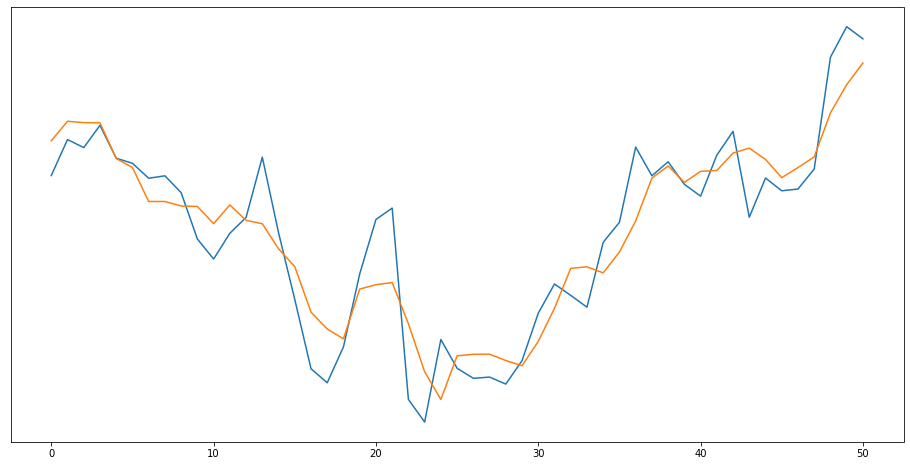

In [ ]:
params = {
  'access_key': "759c804d2d8c3f634671f016532d3584", #API token received from MarketStack
  'symbols' : 'SHOP',
  'date_from' : '2019-01-01',
  'date-to' : '2020-12-21'
}

api_result = requests.get('http://api.marketstack.com/v1/eod', params)

data = api_result.json()['data']

#creationg data scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)

rcParams['figure.figsize'] = 20,10 #configuring graph parameters

#some variables
prices = [] #prices received from WorldTradingData
prices_copy = [] #copy of prices
dates = [entry['date'] for entry in data] #getting dates
real_dates = [] #dates that will be used

for i in range(len(dates)):
    #getting prices for data points in 2019 and past
    if int(dates[i][:4]) >= 2019:
        real_dates.append(dates[i])
        prices.append(float(data[i]["close"]))
        prices_copy.append(float(data[i]["close"]))

#scaling data
prices = np.array(prices, dtype="float").reshape(-1, 1)
prices_copy = np.array(prices_copy, dtype="float").reshape(-1, 1)
scaler.fit(prices)
prices = scaler.transform(prices)
prices_copy = scaler.transform(prices_copy)

#converting dates
for i in range(len(real_dates)):
    real_dates[i] = pd.to_datetime(real_dates[i])

#finishing prices formatting
prices = np.array(prices, dtype="float").reshape(1, -1)
prices = prices[0]
prices_copy = np.array(prices_copy, dtype="float").reshape(1, -1)
prices_copy = prices_copy[0]

#flipping order for prices so that they're from least to most recent
for i in range(len(prices)):
    prices[i] = prices_copy[len(prices) - 1 - i]

#creating price test data
X_train= []
y_train = []

#creating sets of 49 with the 50th as the answer
for i in range(len(prices)):
    try:
        if len(prices[i:i+49]) != 49:
            raise Exception
        if i <= len(prices) - 50:
            X_train.append(prices[i:i+49])
            y_train.append(prices[i+49])
        print(i)
    except:
        pass

for i in range(len(X_train)):
    X_train[i] = [X_train[i]]

X_train = np.array(X_train, dtype="float")
y_train = np.array(y_train, dtype="float")

#neural network
model = keras.Sequential([
        keras.layers.LSTM(units=49, return_sequences=True, input_shape=(1,49)),
        keras.layers.LSTM(units=49, input_shape=(49,)),
        keras.layers.Dense(1),
])

#training neural network
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100)

#getting predictions to verify
aapl_predictions = []
plot_data = []

for i in range(len(X_train)):
    aapl_predictions.append(model.predict(np.array([X_train[i]])))

for i in range(len(aapl_predictions)):
    plot_data.append(aapl_predictions[i][0][0])


plt.figure(figsize=(16,8))
plt.gca().yaxis.set_ticks(np.arange(min(prices), max(prices), 10))
plt.plot(y_train, label='Close Price history')

plt.plot(plot_data, label='Close Price history')


[1114550.0, 2295103.0, 3092660.0, 804220.0, 1131874.0, 738882.0, 980499.0, 1430012.0, 1087093.0, 934661.0, 852652.0, 1515633.0, 1252311.0, 1712987.0, 2604854.0, 1185400.0, 1591670.0, 859474.0, 1200739.0, 1684729.0, 1898191.0, 1000023.0, 760239.0, 1521653.0, 869348.0, 1225823.0, 1733116.0, 2936464.0, 3915800.0, 1153618.0, 1261083.0, 1592250.0, 1110814.0, 1523432.0, 2677709.0, 3466825.0, 1677406.0, 1683073.0, 1413523.0, 1033623.0, 983229.0, 994395.0, 893206.0, 975128.0, 1069782.0, 1062872.0, 1203587.0, 1121842.0, 1323818.0, 1127654.0, 1078788.0, 1252493.0, 1452399.0, 1568595.0, 1328222.0, 1754401.0, 1931324.0, 3122027.0, 1870883.0, 1980814.0, 1644113.0, 1830203.0, 2490097.0, 2215331.0, 2423366.0, 3742355.0, 3609841.0, 1828419.0, 1654750.0, 1639237.0, 1721149.0, 1803438.0, 2085053.0, 3463374.0, 2835801.0, 2695327.0, 2070450.0, 1118763.0, 1322997.0, 1547265.0, 2790300.0, 1676697.0, 1816017.0, 1249642.0, 1315768.0, 1227414.0, 1251729.0, 1264022.0, 1592484.0, 1396585.0, 1700528.0, 2255171.0,

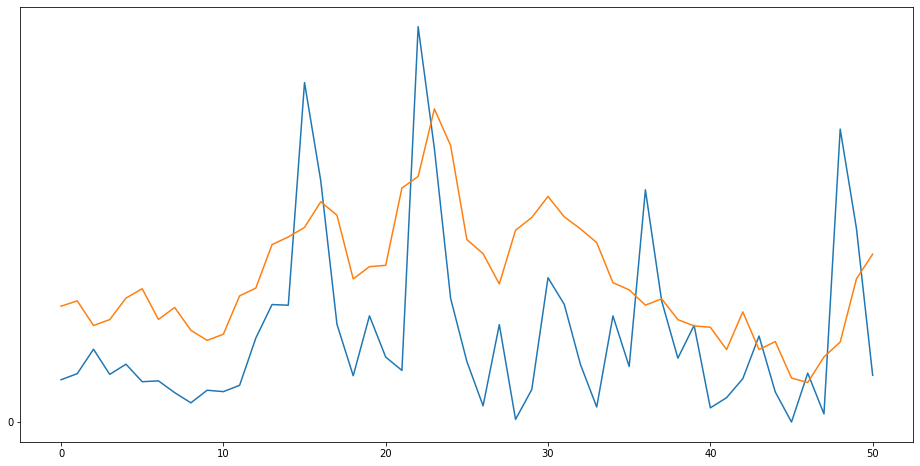

In [ ]:


#volume values
volumes = []
volumes_copy = []

for i in range(len(dates)):
    #getting volume for 2019 and above
    if int(dates[i][:4]) >= 2019:
        volumes.append(float(data[i]["volume"]))
        volumes_copy.append(float(data[i]["volume"]))

print(volumes)

#scaling volumes
volumes = np.array(volumes, dtype="float").reshape(-1, 1)
volumes_copy = np.array(volumes_copy, dtype="float").reshape(-1, 1)

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(volumes)
volumes = scaler.transform(volumes)
volumes_copy = scaler.transform(volumes_copy)

#finishing formatting
volumes = np.array(volumes, dtype="float").reshape(1, -1)
volumes = volumes[0]
volumes_copy = np.array(volumes_copy, dtype="float").reshape(1, -1)
volumes_copy = volumes_copy[0]

#flipping volume so it's least to most recent
for i in range(len(volumes)):
    volumes[i] = volumes_copy[len(volumes) - 1 - i]

#creating training data
X_train_volume = []
y_train_volume = []

for i in range(len(volumes)):
    try:
        if len(volumes[i:i+49]) != 49:
            raise Exception
        if i <= len(volumes) - 50:
            X_train_volume.append(volumes[i:i+49])
            y_train_volume.append(volumes[i+49])
        print(i)
    except:
        pass

for i in range(len(X_train_volume)):
    X_train_volume[i] = [X_train_volume[i]]

X_train_volume = np.array(X_train_volume, dtype="float")
y_train_volume = np.array(y_train_volume, dtype="float")

#neural network
volume_model = keras.Sequential([
        keras.layers.LSTM(units=49, return_sequences=True, input_shape=(1,49)),
        keras.layers.LSTM(units=49),
        keras.layers.Dense(1),
])

#training neural network
volume_model.compile(loss='mean_squared_error', optimizer='adam')

volume_model.fit(X_train_volume, y_train_volume, epochs=200)

#makign some predictions to verify
aapl_predictions_volume = []
plot_data_volume = []

for i in range(len(X_train_volume)):
    aapl_predictions_volume.append(model.predict(np.array([X_train_volume[i]])))

for i in range(len(aapl_predictions_volume)):
    plot_data_volume.append(aapl_predictions_volume[i][0][0])


plt.figure(figsize=(16,8))
plt.gca().yaxis.set_ticks(np.arange(min(volumes), max(volumes), 10))
plt.plot(y_train_volume, label='Close Price history')

plt.plot(plot_data_volume, label='Close Price history')


------------------------------------------------------------------------------------------
-1.6138339107273152
[[0.9127586]]
------------------------------------------------------------------------------------------
-1.9813123914435313
[[0.73113436]]
------------------------------------------------------------------------------------------
-2.277227954616921
[[0.5992026]]
------------------------------------------------------------------------------------------
-2.2670049365579867
[[0.4320128]]
------------------------------------------------------------------------------------------
-1.9545684459681882
[[0.376961]]
------------------------------------------------------------------------------------------
-2.0187010189871937
[[0.3475997]]
------------------------------------------------------------------------------------------
-2.421051935760876
[[0.35467625]]
------------------------------------------------------------------------------------------
-2.1535523050023637
[[0.29603374]]


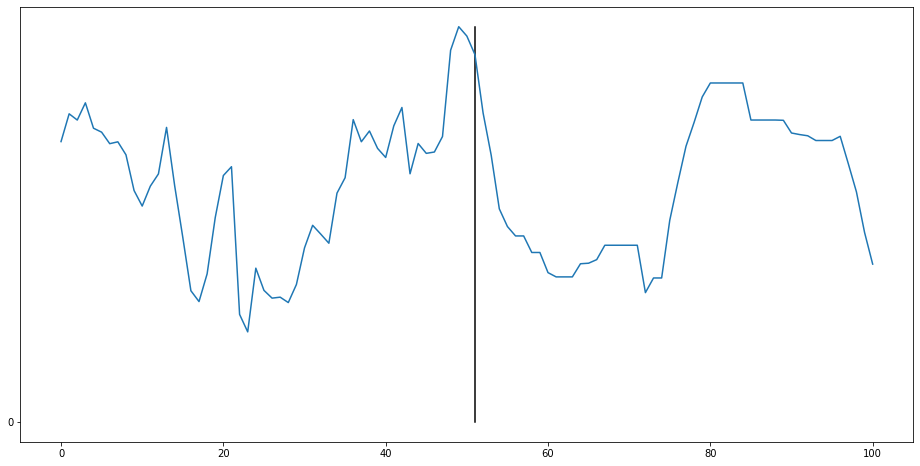

In [ ]:

#getting the last 49 volumes
final_set_volume = X_train_volume[len(X_train_volume) - 1]

final_set_copy_volume = X_train_volume[len(X_train_volume) - 1]

preds = [] #array of predictions

#making volume predictions
for i in range(50):
    pred = volume_model.predict(np.array([final_set_volume], dtype="float"))
    preds.append(pred)
    final_set_volume = np.delete(final_set_volume[0], 0)
    final_set_volume = [final_set_volume]
    final_set_volume = np.append(final_set_volume, pred)
    final_set_volume = [final_set_volume]

#reformatting volume predictions
setted_volume = []

for i in range(len(preds)):
    setted_volume.append(preds[i][0][0])

#function for calculating obv
def calc_obv(volume_set, price_set):
    obv = 0
    try:
        volume_set_copy = volume_set[0] #line added due to potential difference in formatting, both try and except blocks do the same thing
        #adds if price change is up, subtracts if down
        for i in range(1, len(volume_set_copy)):
            if price_set[i] > price_set[i-1]:
                obv += volume_set_copy[i-1]
            else:
                obv -= volume_set_copy[i-1]
    except:
        #adds if price change is up, subtracts if down
        for i in range(1, len(volume_set)):
            if price_set[i] > price_set[i-1]:
                obv += volume_set[i-1]
            else:
                obv -= volume_set[i-1]
    return obv

final_set = X_train[len(X_train) - 1]

final_set_copy = X_train[len(X_train) - 1]

preds = []

obv = calc_obv(final_set_copy_volume[0], final_set_copy[0])

for i in range(50):
    print("------------------------------------------------------------------------------------------")
    print(obv)
    #making prediction
    pred = model.predict(np.array([final_set], dtype="float"))
    print(pred)
    preds.append(pred[0][0])
    pred = pred[0][0]
    #print(preds)
    #making obv corrections
    if obv > 0:
        if pred > preds[i-1]:
            pass
        elif pred < preds[i-1]:
            change = pred - preds[i-1]
            preds[i] = preds[i] - change
    elif obv < 0:
        if pred < preds[i-1]:
            pass
        elif pred > preds[i-1]:
            change = pred - preds[i-1]
            preds[i] = preds[i] - change
    #print(preds)
    #formatting
    final_set = np.delete(final_set[0], 0)
    final_set = [final_set]
    final_set = np.append(final_set, pred)
    final_set = [final_set]
    final_set_copy_volume = np.delete(final_set_copy_volume[0], 0)
    final_set_copy_volume = [final_set_copy_volume]
    final_set_copy_volume = np.append(final_set_copy_volume, setted_volume[i])
    final_set_copy_volume = [final_set_copy_volume]
    obv = calc_obv(final_set_copy_volume, final_set[0]) #calculating obv

#making graph of predictions

preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
preds = preds.reshape(50)

y_train_copy = scaler.inverse_transform(np.array(y_train).reshape(-1, 1))
y_train_copy = y_train_copy.reshape(51)

plt.figure(figsize=(16,8))
plt.gca().yaxis.set_ticks(np.arange(min(y_train), max(y_train), 10))

l = mlines.Line2D([len(X_train), len(X_train)], [0, max(y_train_copy)], color="black")
plt.gca().add_line(l)

prev = final_set_copy[0]

plt.plot(np.concatenate((y_train_copy, preds)), label='Close Price history')